<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> What to diffuse? The basics! </b></div>


|![Probabilistic Graphical Model Diagram](https://hojonathanho.github.io/diffusion/assets/img/pgm_diagram_xarrow.png "Probabilistic Graphical Model Diagram")
|:--:|
|Diagram from [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239)|


<div style="padding: 20px; border-color: #a61d2f; border-radius: 0px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #1279D4; width: 75%; margin: 0 auto; background-color: #1279D4;">
    <p style="font-size: 20px; font-family: 'Georgia'; line-height: 1.5em;">
    “A diffusion model is a parameterised Markov Chain trained using variational inference to produce samples matching the data after finite time.” - <a href="https://arxiv.org/pdf/2006.11239" style="color: #0000EE; text-decoration: underline;">Denoising Diffusion Probabilistic Models</a>
    </p>
</div>

This is a direct quote from the paper, that introduced diffusion models, but how do you make one and what is the intuition behind these diffusion models? That is what I want to explain in this post.
It consist out of the following parts;

- What can we do with diffusion models and why do they exists?
- What are the underlying assumptions we make about this diffusion process?
- How do we convert these underlying assumptions to a loss function that we can use to train a model.
- How do we go from loss function to a trainable model and train it?

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> What can we do with diffusion models? </b></div>
|![Probabilistic Graphical Model Diagram](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/DiffusionModels/00-SampleSpace.png?raw=true)
|:--:|

At its core, diffusion models are generative models used to generate new samples of a distribution. The idea behind generative modelling is to derive for a given dataset $\mathcal{D}$ of observations $x^{(1)}, \cdots x^{(N)}$ to learn or derive the underlying distribution from which the data is generated. Thus derive $x \sim p_{data}$. Which enables us to sample from this distribution and thus generate more samples, which is the goal of diffusion models. 

The sample space for images is $x \in \mathbb{R}^{H\times W}$,  is incredibly big, while most of this space is occupied mostly be noisy samples. As I attempted to visualise in the picture above.

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> Generating samples </b></div>
As mentioned before, we want to sample previously unseen examples, thus we need a mapping that produces a sample inside the space $x \in \R^{H\times W}$. A Generative Adversarial Network (GAN), is a technique that produces such a mapping (the generator). This generator takes as input noise and outputs an image 
|![Probabilistic Graphical Model Diagram](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/DiffusionModels/01-GAN.png?raw=true)
|:--:|

$$
g_\theta(x_{noise}) = x_{img}
$$

GANs however have two major problems;

- Mode collapse, this meant that the generator only learned to predict one specific sample. Thus it collapses the whole space $\{x | p_{true}(x) \geq 0.9
\}$ into one sample.
- Unstable training, due to the adversarial nature of a GAN, you have to train a generator and discriminator together. When the complexity of the discriminator and the generator are not balanced, the two models will just stop learning from each other and nothing sensible happens.

Diffusion models solve these problems by modeling the underlying data distribution in a sequential way. 
|![Probabilistic Graphical Model Diagram](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/DiffusionModels/02-Diffusion.png?raw=true)
|:--:|

In this way the training objective becomes more stable, since the whole problem is split into many smaller problems. And it doesn’t require the training of a discriminator, since the it just learns to denoise samples.

A different way to look at diffusion models that I found very useful is that of the perspective of score models, that basically says that diffusion models try to a score function $s(x)$, which is the gradient of the log likelihood and points, for each point $x \in \mathbb{R}^{H\times W}$to the direction that makes your sample more likely.
|![Probabilistic Graphical Model Diagram](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/DiffusionModels/03-ScoreFunction.png?raw=true)
|:--:|
$$
s(x) \approx \nabla_x \log{p(x)} \Big(= \epsilon_\theta(x, t) \Big)
$$

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> Diffusion models - Forward process </b></div>
This part explain the math behind diffusion models and how to get a loss function we will employ to train a model. Most of the math comes from the blogpost [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) and from the paper [link](https://arxiv.org/pdf/2006.11239). I have rewritten the equations and added the schematics in way that it makes more sense to me, and I hope it makes it helps you as well.

As just mentioned, diffusion models make the assumption that samples are sequentially constructed from noise. This means that there is a sequence of hidden latent variables that starts with $x_T \sim \mathcal{N}(0, \sigma^2)$ where gradually information is added (or de-noised), until there is a clean sample without noise $x_0$. 

Before I can explain how to generate data, I need to start with the forward process, the process where data is destroyed. 

This is defined by the approximate posterior. 

$$
q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})
$$

With the transition probabilities.

$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t|\sqrt{1-\beta_t} x_{t-1}, \beta_tI)
$$

Where the sequence $\beta_0, \cdots, \beta_{T}$ is the variance schedule that controls how fast information is destroyed in the process. Using the [reparameterization trick](https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) we can expess $x_t$

$$
x_{t} = \sqrt{1-\beta_{t-1}} \cdot x_{t-1} + \sqrt{\beta_{t-1}} \cdot \epsilon_{t-1}
$$

Were

$$
\epsilon \sim \mathcal{N}(0, I)
$$

The reason why this setup is so convenient is that we can use this property to derive a tractable form for $x_t$

$$
\begin{align*}
x_{t} &= \sqrt{1-\beta_{t-1}} \cdot x_{t-1} + \sqrt{\beta_{t-1}} \cdot \epsilon_{t-1} \\
x_{t} &= \sqrt{1-\beta_{t-1}} \cdot (\sqrt{1-\beta_{t-2}} \cdot x_{t-2} + \sqrt{\beta_{t-2}} \cdot \epsilon_{t-2}) + \sqrt{\beta_{t-1}} \cdot \epsilon_{t-1} \\
x_{t} &= \sqrt{1-\beta_{t-1}}  \sqrt{1-\beta_{t-2}} \cdot x_{t-2} + \sqrt{1-\beta_{t-1}}\sqrt{\beta_{t-2}} \cdot \epsilon_{t-2} +  \sqrt{\beta_{t-1}} \cdot \epsilon_{t-1} \\
\vdots \\
x_{t} &= \sqrt{\bar{\alpha}_t} x_0 + \sqrt{(1-\bar{\alpha}_t)}\cdot\epsilon_{combined}
\end{align*}
$$

 Gaussian distribution to derive a tractable form;

$$
q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I)
$$

Where we use the identities

$$
\alpha_t = 1-\beta_t \\
\bar{\alpha}=\prod_{s=1}^t\alpha_t
$$

This simply means that we can sample $x_t$ for arbitrary $t$ using the reparameterization trick. 

Before we are finished with the forward process, I want to define one more probability, the forward process posteriors;

$$
q(x_{t-1}|x_t ,x_0)  = \mathcal{N}(x_{t-1};\hat{\mu}_t(x_t, x_0), \hat{\beta}_t)
$$

Where

$$
\hat{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar\alpha_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{{1-\bar\alpha}_t}x_t
$$

And

$$
\hat{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar\alpha_t}\beta_t
$$

The reason why this guy is important will be clear at the end of the blogpost. Now we know, how we can derive, given a sample $x \in \mathcal{D}$, a latent $x_t$ for an arbitrary $t$.
|![Probabilistic Graphical Model Diagram](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/DiffusionModels/05-Forward.png?raw=true)
|:--:|

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> Diffusion models - Reverse process </b></div>

So, now we have defined the forward process, lets look at what we actually want to learn, namely the reverse process. This process is defined by 

$$
p_\theta(x_0) = \int p_\theta(x_0, x_1, \cdots, x_{T-1}) d{x_{1:T}}
$$

$$
p_\theta(x_0, \cdots, x_{T-1}) = p_\theta(x_0)\prod_{t=1}^Tp_\theta(x_{t-1}|x_t)
$$

In this reverse process the transitions are assumed to be 

$$
\begin{align*}
p_{\theta}(x_{t-1}|x_t)  &= \mathcal{N}\Big(x_{t-1};\mu_\theta(x_t, t), \hat{\beta}_t \mathbf{I}\Big ) 
\end{align*}
$$

Where $\mu_\theta(x_t, t)$ is the function distribution we want to learn! This function we can rewrite to;

$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \Big(x_t - \frac{\beta_t}{\sqrt{1-\hat\alpha_t}}\epsilon_\theta(x_t, t) \Big)
$$

When we have this function $p_\theta(x_{t-1}|x_t)$, we can use the resample trick to sequentially reconstruct samples from noise.


<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> Diffusion models - From definition to loss function </b></div>


So we just defined the diffusion process as a Markov chain, now we need to come up with a loss which we can use to optimise the parameters of our model $\theta$.

Starting with the joint distribution can be done by minimising the log-likelihood for the model;

$$
\begin{align*}
&=-\log \big( p_{\theta}(x) \big) = -\log \big( \int p_\theta(x_{0:T})dx_{1:T} \big) \\
&=-\log \big( \int p_\theta(x_{0:T})\cdot \frac{q(x_{1:T}|x_0)}{q(x_{1:T}|x_0)} dx_{1:T} \big) \\
&= -\log \big(\mathbb{E}_q\Big[ \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \Big] \big)\leq -\mathbb{E}_q\Big[\log \big( \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \Big) \Big] \\
&=-\mathbb{E}_q\Big[-\log p(x_T) - \sum_{t\geq 1} \log \{\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}\} \Big]
\end{align*}
$$

The problem with this is that we are now comparing $p_\theta(x_{t-1}|x_t)$  with $q(x_t|x_{t-1})$. It would be way nicer if we could compare for each timestep $t$, the approximate reverse forward process with the posterior forward process, $q(x_{t-1}|x_t, x_0)$ (which we just derived). This can be done by rewriting if we substitute;

$$
q(x_t|x_{t-1}) = \frac{q(x_t|x_0)}{q(x_{t-1}|x_0)} \cdot q(x_{t-1}|x_t, x_0)\\
$$

To obtain

$$
\begin{align*}
&=-\mathbb{E}_q\Big[-\log p(x_T) - \sum_{t\geq 1} \log \{\frac{p_\theta(x_{t-1} |x_t)}{q(x_t|x_{t-1})}\} \Big] \\
&=-\mathbb{E}_q\Big[-\log p(x_T) - \sum_{t>1} \log \{\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}\} -\log \big\{ \frac{p_\theta(x_0|x_1)}{q(x_1|x_0)}\big\}\Big] \\
&=-\mathbb{E}_q\Big[-\log p(x_T) - \sum_{t>1} \log \Bigg\{\frac{p_\theta(x_{t-1}|x_t}{q(x_{t-1}|x_t, x_0)}\cdot\frac{q(x_{t-1}|x_0)} {q(x_t|x_0)}\Bigg\} -\log \big\{ \frac{p_\theta(x_0|x_1)}{q(x_1|x_0)}\big\}\Big] \\
\end{align*}
$$

Rewritting 

$$
-\sum_{t>1}\log\Bigg\{\frac{q(x_{t-1}|x_0)} {q(x_t|x_0)}\Bigg\} = \log q(x_1|x_0) - \log q(x_T|x_0)
$$

And substitution gives us

$$
\begin{align*}
&=-\mathbb{E}_q\Big[-\log p(x_T) - \sum_{t>1} \log \Bigg\{\frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t, x_0)}\cdot\frac{q(x_{t-1}|x_0)} {q(x_t|x_0)}\Bigg\} -\log \big\{ \frac{p_\theta(x_0|x_1)}{q(x_1|x_0)}\big\}\Big] \\
&=-\mathbb{E}_q\Big[ - \log \Big\{\frac{p(x_T)}{q(x_T|x_0)}\Big\} - \sum_{t>1} \log \Bigg\{\frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t, x_0)}\Bigg\} - \log\big\{p_\theta(x_0|x_1)\big\}\Big]
\end{align*}
$$

This means that if we want parameters $\theta$ that minimises the log-likelihood, we need to make sure that these parameters minimises a lower bound which consist out of the following terms;

$$
\begin{align*}
\mathbb{E}_q\Big[&D_{KL}\big[q(x_1|x_0)||p(x_1|x_0)\big] \\
&+ \sum_{t>1}D_{KL}\big[q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t) \big]
\\ &-\log p_\theta(x_0|x_1)
\Big]
\end{align*}
$$

Which we can decompose into;

$$
\begin{align*}
&L_T = D_{KL}\big[q(x_T|x_0)||p(x_T)\big] \\
&L_{t-1} = \sum_{t>1}D_{KL}\big[q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t) \big]\\
&L_0 = - \log p_\theta(x_0|x_1)
\end{align*}
$$

This basically says that we can optimise the lower bound by only looking at $L_{t-1}$, because $L_T$  is constant during training and can be ignored. 

Because both $p_\theta$ and $q$ are both Gaussians, the divergence becomes;

$$
L_{t-1} = \mathbb{E}_q\Big[\frac{1}{2\sigma^2_t}||\hat\mu(x_t, x_0) - \mu_\theta(x_t, t)||^2\Big]
$$

This means that the most straightforward way to implement the reverse diffusion process is to simply predict $\mu(x_t, x_0)$. This is the first way to implement a diffusion model. 

The second way is rewriting to;

$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \Big(x_t - \frac{\beta_t}{\sqrt{1-\hat\alpha_t}}\epsilon_\theta(x_t, t) \Big)
$$

The authors of the paper found this more convenient.
Which leads to an even simpler version of the lower bound
$$
L_{simple}(\theta) = \mathbb{E}\Big[||\epsilon - \epsilon_\theta(\sqrt{\hat\alpha_t}x_0 +\sqrt{1-\hat\alpha_t}\epsilon, t)||^2\Big]
$$

In this way we don’t directly predict, given a variable $x_t$ what was the previous $x_{t-1}$, but we predict, given $x_t$, what the noise $\epsilon_{\theta}(x_t, t)$ at that given timestep. Intuitively, we predict which direction we have to move to make our sample less noisy.
|![Probabilistic Graphical Model Diagram](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/DiffusionModels/06-DiffusionLoss.png?raw=true)
|:--:|



<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> UNET architecture </b></div>
|![Probabilistic Graphical Model Diagram](https://github.com/JPABotermans/KaggleNotebooks/blob/main/Images/DiffusionModels/06-Unet.png?raw=true)
|:--:|
|UNET diagram from [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)|


So now we know what we want, namely $\epsilon_\theta(x, t)$, a model that takes as input a distorted sample $x_t$ and outputs the noise $\epsilon$ that was added for timestep $t$ and we know that we want to apply a mse loss on this model. So for this we use an UNET, just like the authors of the original diffusion models, and we use a convolution with a shift scale operation to condition this on the timestep. 


This UNET consist out of a few building blocks which I will explain from small to big, starting with a basic convolutional block;

```python
class ConvBlock(torch.nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1,
                 bias: bool = False,
                 nrm: bool = True,
                 act: bool = True,
                ) -> None:
        """A basic convolutional block, convolution, activation and normalization. Uses Groupnorm.
        """
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding, 
            bias=bias)
        
        self.nrm_fn = torch.nn.GroupNorm(num_groups=8, num_channels=out_channels) if nrm else torch.nn.Identity()
        self.act_fn = torch.nn.LeakyReLU(inplace=True) if act else torch.nn.Identity()

    def forward(self, x) -> torch.Tensor:
        return self.act_fn(self.nrm_fn(self.conv(x)))
```

However, we want a model that can be conditioned on time $t$, we use a shift-scale operation on the output of a normal convolution layer. 

```python
class TimeConvBlock(ConvBlock):
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t_scale, t_shift = t.chunk(2, dim=1)
        x = self.nrm_fn(self.conv(x))
        return self.act_fn(x * (1 + t_scale[..., None, None]) + t_shift[..., None, None])
```

These `TimeConvBlocks` will be combined to make a `TimeResidualBlock`.

```python
class TimeResidualBlock(torch.nn.Module):
    """Basic residual block with time conditioning.
    Time conditioning is done by employing a scale/shift operator on the projected features before the activation.
    Contains 3 convolutional blocks, the last one without activation.
    The residual connection is added to the last output.
    """
    def __init__(self, channels: int) -> None:
        super().__init__()
        self.conv_block_1 = TimeConvBlock(in_channels=channels, out_channels=channels)
        self.conv_block_2 = TimeConvBlock(in_channels=channels, out_channels=channels)
        self.conv_block_3 = TimeConvBlock(in_channels=channels, out_channels=channels, act=False)
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        r = x.clone()
        x = self.conv_block_1(x=x,t=t)
        x = self.conv_block_2(x=x,t=t)
        return self.conv_block_3(x=x,t=t) + x
```

Both an an EncoderBlock and a DecoderBlock consist out of one `TimeResidualBlock` and a `Resample Block`. In the `EncoderBlock` the resample operation is done first, while in the `DecoderBlock` the resample operation is done last, such that the `TimeResidualBlock` operates on features maps of low resolution. 

```python
class ResidualUnetBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample: bool, time_channels: int) -> None:
        super().__init__()
        self.upsample = upsample
        if self.upsample:
            #This means it is an decoder block, so we do the first the convolution block, then the resample block
            self.residual_block = TimeResidualBlock(channels=in_channels)
            self.resample_block = ConvUpsample(in_channels=in_channels, out_channels=out_channels)
        else:
            #This means that it is an encoder block so first resample, then convolutional block
            self.resample_block = ConvDownSample(in_channels=in_channels, out_channels=out_channels)
            self.residual_block = TimeResidualBlock(channels=out_channels)
        self.timestep_block = torch.nn.Sequential(
                torch.nn.Linear(time_channels, out_channels*2 if not upsample else in_channels*2),
                torch.nn.SiLU(),
            )
        
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        h = x.clone()
        t = self.timestep_block(t)
        if not self.upsample:
            x = self.resample_block(x)
        x = self.residual_block(x=x, t=t)
        if self.upsample:
            x = self.resample_block(x)        
        return x, h
```

Combining these blocks gives our model


```python
class UNET(torch.nn.Module):
    
    def __init__(self, in_channels: int, channels: list[int]) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.channels = channels
        self.init_cnv = ConvBlock(in_channels=in_channels, out_channels=channels[0])
        time_channels = channels[0] * 4
        self.time_enc = torch.nn.Sequential(
            SinusoidalPositionEmbeddings(time_channels=channels[0]*4),
            torch.nn.Linear(channels[0]*4, channels[0]*4),
            torch.nn.SiLU(),
        )

        #Encoder/decoder
        self.encoder = torch.nn.ModuleList([])
        self.decoder = torch.nn.ModuleList([])
        for in_channels, out_channels in zip(channels[:-1], channels[1:]):
            self.encoder.append(ResidualUnetBlock(in_channels, out_channels, time_channels=time_channels, upsample=False))
            self.decoder.append(ResidualUnetBlock(out_channels*2, in_channels,time_channels=time_channels,  upsample=True))
        
        self.attn_block = Attention2D(in_channels=channels[-1], out_channels=channels[-1]*2, head_channels=16, n_heads=4)
        self.attn_norm = torch.nn.GroupNorm(num_groups=1, num_channels=channels[-1]*2)
        self.final_cnv = ConvBlock(in_channels=channels[0]*2, out_channels=self.in_channels, nrm=False, act=False, )
        
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = self.init_cnv(x)
        t = self.time_enc(t)

        skip_connection = []
        for layer in self.encoder:
            x, h = layer(x=x, t=t)
            skip_connection.append(h)
        x = self.attn_block(x)
        x = self.attn_norm(x)
        
        for layer in self.decoder[::-1]:
            x, _ = layer(x=x, t=t)
            x = torch.cat((x, skip_connection.pop(-1)), dim=1)
            
        return self.final_cnv(x)
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import einops
from tqdm import tqdm

In [2]:
batch_size = 64
eval_steps = 100
learning_rate = 0.0001
beta_start = 0.0001
beta_end = 0.015
diffusion_timesteps = 1000
n_trn_steps = 5_000

In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.0,), (1.0,))])
dataset = torchvision.datasets.MNIST(root=".", transform=transforms, train=True, download=True)

loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.78MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
def get_diffusion_dict_np(
    beta_start: float, beta_end: float, diffusion_timesteps: int
) -> dict[str, np.ndarray]:
    betas = np.linspace(beta_start, beta_end, diffusion_timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas, axis=0)
    alphas_cumprod_prev = np.pad(alphas_cumprod[:-1], (1, 0), constant_values=1.0)
    sqrt_recip_alphas = np.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance,
    }


In [5]:
def q_sample(
    gaussian_dict_np: dict[str, np.ndarray],
    x_start: np.ndarray,
    timesteps: np.ndarray,
    noise: np.ndarray,
) -> np.ndarray:
    """Forward process, this we add noise to x_start=x0.
    The amount of noise we add is defined by the variance schedule defined.

    Args:
        x_start (torch.Tensor): Start 
        t (int): Diffusion timestep, this value determines the scale of the noise we will add.
        noise (torch.Tensor, optional): The noise to add, this is the amount of noise the network should predict.
    Returns:
        torch.Tensor: x_t
    """

    sqrt_alphas_cumprod_t = gaussian_dict_np["sqrt_alphas_cumprod"][timesteps]
    sqrt_one_minus_alphas_cumprod_t = gaussian_dict_np["sqrt_one_minus_alphas_cumprod"][
        timesteps
    ]

    return sqrt_alphas_cumprod_t.reshape(-1, 1, 1, 1) * x_start + sqrt_one_minus_alphas_cumprod_t.reshape(-1, 1, 1, 1) * noise

In [6]:
class ConvBlock(torch.nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1,
                 bias: bool = False,
                 nrm: bool = True,
                 act: bool = True,
                ) -> None:
        """A basic convolutional block, convolution, activation and normalization. Uses Groupnorm.
        """
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding, 
            bias=bias)
        
        self.nrm_fn = torch.nn.GroupNorm(num_groups=8, num_channels=out_channels) if nrm else torch.nn.Identity()
        self.act_fn = torch.nn.LeakyReLU(inplace=True) if act else torch.nn.Identity()

    def forward(self, x) -> torch.Tensor:
        return self.act_fn(self.nrm_fn(self.conv(x)))

In [7]:
class TimeConvBlock(ConvBlock):
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t_scale, t_shift = t.chunk(2, dim=1)
        x = self.nrm_fn(self.conv(x))
        return self.act_fn(x * (1 + t_scale[..., None, None]) + t_shift[..., None, None])

In [8]:
class ConvDownSample(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, )
        self.nrm_fn = torch.nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.act_fn = torch.nn.LeakyReLU(inplace=True)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act_fn(self.nrm_fn(self.conv(x)))

In [9]:
class ConvUpsample(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels:int, ) -> None:
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, )
        self.nrm_fn = torch.nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.act_fn = torch.nn.LeakyReLU(inplace=True)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.nn.functional.interpolate(x, scale_factor=2, )
        return self.act_fn(self.nrm_fn(self.conv(x)))

In [10]:
class TimeResidualBlock(torch.nn.Module):
    """Basic residual block with time conditioning.
    Time conditioning is done by employing a scale/shift operator on the projected features before the activation.
    Contains 3 convolutional blocks, the last one without activation.
    The residual connection is added to the last output.
    """
    def __init__(self, channels: int) -> None:
        super().__init__()
        self.conv_block_1 = TimeConvBlock(in_channels=channels, out_channels=channels)
        self.conv_block_2 = TimeConvBlock(in_channels=channels, out_channels=channels)
        self.conv_block_3 = TimeConvBlock(in_channels=channels, out_channels=channels, act=False)
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        r = x.clone()
        x = self.conv_block_1(x=x,t=t)
        x = self.conv_block_2(x=x,t=t)
        return self.conv_block_3(x=x,t=t) + x

In [11]:
class ResidualUnetBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample: bool, time_channels: int) -> None:
        super().__init__()
        self.upsample = upsample
        if self.upsample:
            #This means it is an decoder block, so we do the first the convolution block, then the resample block
            self.residual_block = TimeResidualBlock(channels=in_channels)
            self.resample_block = ConvUpsample(in_channels=in_channels, out_channels=out_channels)
        else:
            #This means that it is an encoder block so first resample, then convolutional block
            self.resample_block = ConvDownSample(in_channels=in_channels, out_channels=out_channels)
            self.residual_block = TimeResidualBlock(channels=out_channels)
        self.timestep_block = torch.nn.Sequential(
                torch.nn.Linear(time_channels, out_channels*2 if not upsample else in_channels*2),
                torch.nn.SiLU(),
            )
        
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        h = x.clone()
        t = self.timestep_block(t)
        if not self.upsample:
            x = self.resample_block(x)
        x = self.residual_block(x=x, t=t)
        if self.upsample:
            x = self.resample_block(x)        
        return x, h

In [12]:
class Attention2D(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, head_channels: int, n_heads: int, ) -> None:
        """Attention block that computes the self attention for each feature.
        
        First projects the features to Q, K, V embeddings.
        Reshapes these blocks by collapsing the H, W axis.
        Then computes a similarity score.
        Then computes the output values.
        """
        super().__init__()
        
        self.embedding_dim = head_channels * n_heads
        self.q_scale = head_channels ** -0.5
        self.n_heads = n_heads
        self.out_channels = out_channels
        self.conv_q = torch.nn.Conv2d(in_channels=in_channels, out_channels=self.embedding_dim, kernel_size=1, stride=1, padding=0, bias=False)
        self.conv_k = torch.nn.Conv2d(in_channels=in_channels, out_channels=self.embedding_dim, kernel_size=1, stride=1, padding=0, bias=False)
        self.conv_v = torch.nn.Conv2d(in_channels=in_channels, out_channels=self.embedding_dim, kernel_size=1, stride=1, padding=0, bias=False)

        self.conv_out = torch.nn.Conv2d(in_channels=self.embedding_dim, out_channels=self.out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        N, C, H, W = x.shape
        q = self.conv_q(x)
        k = self.conv_k(x)
        v = self.conv_v(x)

        # re-arrange the q, k, v from (N, C, H, W) to (N, n_heads, head_channels, HxW)
        q = einops.rearrange(q, pattern="N (a b) H W -> N a b (H W)", a=self.n_heads) * self.q_scale
        k = einops.rearrange(k, pattern="N (a b) H W -> N a b (H W)", a=self.n_heads)
        v = einops.rearrange(v, pattern="N (a b) H W -> N a b (H W)", a=self.n_heads)

        similarity_matrix = torch.einsum("N a b i, N a b j -> N a i j", q, k)
        similarity_matrix = torch.nn.functional.softmax(similarity_matrix, dim=1)

        output = torch.einsum("N a i j, N a d j -> N a i d", similarity_matrix, v)
        output = einops.rearrange(output, "N a (H W) d->N (a d) H W",  H=H, W=W)
        return self.conv_out(output)

In [13]:
class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, time_channels: int) -> None:
        super().__init__()
        self.time_channels = time_channels
        self.embeddings = torch.log(torch.Tensor([10_000])) / (self.time_channels // 2 - 1)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        embeddings = torch.exp(torch.arange(self.time_channels // 2, device=t.device) * -self.embeddings.to(t.device))
        embeddings = t[:, None] * embeddings[None, :]
        return torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

In [14]:
class UNET(torch.nn.Module):
    
    def __init__(self, in_channels: int, channels: list[int]) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.channels = channels
        self.init_cnv = ConvBlock(in_channels=in_channels, out_channels=channels[0])
        time_channels = channels[0] * 4
        self.time_enc = torch.nn.Sequential(
            SinusoidalPositionEmbeddings(time_channels=channels[0]*4),
            torch.nn.Linear(channels[0]*4, channels[0]*4),
            torch.nn.SiLU(),
        )

        #Encoder/decoder
        self.encoder = torch.nn.ModuleList([])
        self.decoder = torch.nn.ModuleList([])
        for in_channels, out_channels in zip(channels[:-1], channels[1:]):
            self.encoder.append(ResidualUnetBlock(in_channels, out_channels, time_channels=time_channels, upsample=False))
            self.decoder.append(ResidualUnetBlock(out_channels*2, in_channels,time_channels=time_channels,  upsample=True))
        
        self.attn_block = Attention2D(in_channels=channels[-1], out_channels=channels[-1]*2, head_channels=16, n_heads=4)
        self.attn_norm = torch.nn.GroupNorm(num_groups=1, num_channels=channels[-1]*2)
        self.final_cnv = ConvBlock(in_channels=channels[0]*2, out_channels=self.in_channels, nrm=False, act=False, )
        
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = self.init_cnv(x)
        t = self.time_enc(t)

        skip_connection = []
        for layer in self.encoder:
            x, h = layer(x=x, t=t)
            skip_connection.append(h)
        x = self.attn_block(x)
        x = self.attn_norm(x)
        
        for layer in self.decoder[::-1]:
            x, _ = layer(x=x, t=t)
            x = torch.cat((x, skip_connection.pop(-1)), dim=1)
            
        return self.final_cnv(x)

In [15]:
def batch_distort(x_trn: torch.Tensor, batch_size: int, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    if t == None:
        t = torch.randint(0, diffusion_timesteps-1, (batch_size,))
    noise = torch.randn_like(x_trn)
    xt = q_sample(gaussian_dict_np=diffusion_dict_np, x_start = x_trn.numpy(), timesteps=t.numpy(), noise=noise.numpy())
    return torch.from_numpy(xt).to(torch.float32), noise, t

In [16]:
def plot_q_sample(x: torch.Tensor, xt: torch.Tensor, ) -> None:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(xt, cmap="binary")
    axs[1].imshow(x, cmap="binary")
    axs[0].set_title(r"$x_t$")
    axs[1].set_title(r"$x_0$")
    _ = [ax.axis("off") for ax in axs.flatten()]

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> Diffusion models - From definition to loss function </b></div>

Okey, now we have everything defined we can finally train our model.

In [17]:
unet = UNET(in_channels=1, channels=[16, 32, 64])
optimizer = torch.optim.Adam(params=unet.parameters(), lr=learning_rate, )
diffusion_dict_np = get_diffusion_dict_np(beta_start=beta_start, beta_end=beta_end, diffusion_timesteps=diffusion_timesteps)

In [18]:
iter_loader = iter(loader)
for step in range(n_trn_steps):
    try: 
        x_trn, _ = next(iter_loader)
    except StopIteration:
        iter_loader = iter(loader)
        x_trn, _ = next(iter_loader)
    xt, noise, t = batch_distort(x_trn=x_trn, batch_size=batch_size, t=None)
    predicted_noise = unet(x=xt, t=t)
    loss = torch.nn.functional.mse_loss(predicted_noise, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % eval_steps == 0:
        print(f"{step}/{n_trn_steps} loss: {loss.item():.4f}")

0/5000 loss: 1.1611
100/5000 loss: 0.4566
200/5000 loss: 0.2470
300/5000 loss: 0.1540
400/5000 loss: 0.1307
500/5000 loss: 0.1065
600/5000 loss: 0.1035
700/5000 loss: 0.0730
800/5000 loss: 0.0828
900/5000 loss: 0.1051
1000/5000 loss: 0.0496
1100/5000 loss: 0.0504
1200/5000 loss: 0.0453
1300/5000 loss: 0.0640
1400/5000 loss: 0.0455
1500/5000 loss: 0.0474
1600/5000 loss: 0.0513
1700/5000 loss: 0.0360
1800/5000 loss: 0.0379
1900/5000 loss: 0.0515
2000/5000 loss: 0.0441
2100/5000 loss: 0.0436
2200/5000 loss: 0.0702
2300/5000 loss: 0.0316
2400/5000 loss: 0.0425
2500/5000 loss: 0.0378
2600/5000 loss: 0.0220
2700/5000 loss: 0.0442
2800/5000 loss: 0.0522
2900/5000 loss: 0.0489
3000/5000 loss: 0.0373
3100/5000 loss: 0.0338
3200/5000 loss: 0.0347
3300/5000 loss: 0.0570
3400/5000 loss: 0.0460
3500/5000 loss: 0.0370
3600/5000 loss: 0.0343
3700/5000 loss: 0.0384
3800/5000 loss: 0.0429
3900/5000 loss: 0.0370
4000/5000 loss: 0.0414
4100/5000 loss: 0.0315
4200/5000 loss: 0.0330
4300/5000 loss: 0.0434


<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> Diffusion models - Sampling steps </b></div>

Okey, now we have our model, we can sample some digits!

In [19]:
with torch.no_grad():
    xt = torch.randn_like(xt)
    for timestep in tqdm(reversed(range(0, diffusion_timesteps-1))):
        t = torch.ones_like(xt[:, 0, 0, 0]) * timestep
        et = unet(x=xt, t=t)
        model_mean = diffusion_dict_np["sqrt_recip_alphas"][timestep] * (xt - diffusion_dict_np["betas"][timestep] * et.detach().numpy() /diffusion_dict_np["sqrt_one_minus_alphas_cumprod"][timestep])
        if timestep != 0:
            xt = model_mean + np.sqrt(
                    diffusion_dict_np["posterior_variance"][timestep]
                ) * torch.randn_like(model_mean)
        else:
            xt = model_mean

999it [02:12,  7.51it/s]


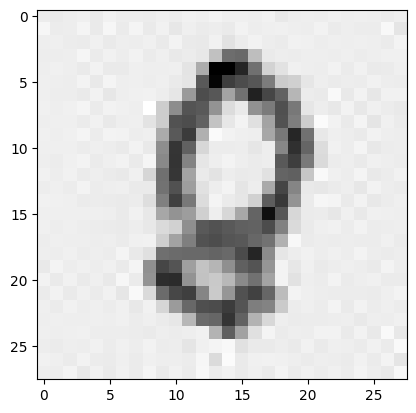

In [20]:
plt.imshow(xt[10, 0].numpy(), cmap="binary")

<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1279D4; overflow:hidden"><b> Diffusion models - Sources </b></div>


This amazing blogpost helped me understand (most of) the math behind diffusion models and inspired me to make my own blogpost combining both the math and python code.
```bib
@article{weng2021diffusion,
  title   = "What are diffusion models?",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2021",
  month   = "Jul",
  url     = "https://lilianweng.github.io/posts/2021-07-11-diffusion-models/"
}

```
This blogpost explained the reparameterization trick.
```bib
@article{weng2018VAE,
  title   = "From Autoencoder to Beta-VAE",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2018",
  url     = "https://lilianweng.github.io/posts/2018-08-12-vae/"
}
```

This work and the [blogpost](https://yang-song.net/blog/2021/score/) inspired most of the schematics
```bib
@inproceedings{
  song2021scorebased,
  title={Score-Based Generative Modeling through Stochastic Differential Equations},
  author={Yang Song and Jascha Sohl-Dickstein and Diederik P Kingma and Abhishek Kumar and Stefano Ermon and Ben Poole},
  booktitle={International Conference on Learning Representations},
  year={2021},
  url={https://openreview.net/forum?id=PxTIG12RRHS}
}
```

The pytorch code I wrote for this blog was written from scratch to help me explain the algorithm, but it was inspired by the [code](https://github.com/openai/improved-diffusion/tree/main) from this work
```bib
@article{DBLP:journals/corr/abs-2102-09672,
  author       = {Alex Nichol and
                  Prafulla Dhariwal},
  title        = {Improved Denoising Diffusion Probabilistic Models},
  journal      = {CoRR},
  volume       = {abs/2102.09672},
  year         = {2021},
  url          = {https://arxiv.org/abs/2102.09672},
  eprinttype    = {arXiv},
  eprint       = {2102.09672},
  timestamp    = {Wed, 24 Feb 2021 15:42:45 +0100},
  biburl       = {https://dblp.org/rec/journals/corr/abs-2102-09672.bib},
  bibsource    = {dblp computer science bibliography, https://dblp.org}
}

```

And ofcourse, to the work on diffusion models;

```bib
@article{DBLP:journals/corr/abs-2006-11239,
  author       = {Jonathan Ho and
                  Ajay Jain and
                  Pieter Abbeel},
  title        = {Denoising Diffusion Probabilistic Models},
  journal      = {CoRR},
  volume       = {abs/2006.11239},
  year         = {2020},
  url          = {https://arxiv.org/abs/2006.11239},
  eprinttype    = {arXiv},
  eprint       = {2006.11239},
  timestamp    = {Tue, 23 Jun 2020 17:57:22 +0200},
  biburl       = {https://dblp.org/rec/journals/corr/abs-2006-11239.bib},
  bibsource    = {dblp computer science bibliography, https://dblp.org}
}
```